# CW5
### Hanlin Liu  02081102

---------------------

In [1]:
# import necessary packages
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from tqdm import tqdm
import matplotlib.pyplot as plt

# plotting preferences updates
colors = ['#132A36', '#780627','#4692BD', '#079069']

# Set plotting parameters
params = {'figure.figsize': (6.0,6.0),
          'axes.labelsize': 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'legend.fontsize': 12,
          'font.size': 12
           }

plt.rcParams.update(params)

In [2]:
# import datas
data = np.loadtxt('lorenz_xz_data.txt').T
t_eval = data[0]
x_data = data[1]
z_data = data[2]

The idea is to use grid search. That is, go through the possible combinations of two parameters with reasonable steps and find a pair of parameters with the lowest synchronization error in $z$ direction. To do this, we need a driver-driven lorenz system driven by $x$ and return $y$ and $z$. Since $x$ is the driver, we need a smooth function $x(t)$ to solve the system with `solve_ivp`. `scipy.interpolate.interp1d` is helpful here.

In [3]:
# function of driver-driven lorenz system
def lorenz_driver_driven(t, state, x_t, params):
    '''
    Parameters: t, time
                state, direction y and z
                x_t, driven function x(t)
                params, parameters for the system

    Return: differential equations for system
    '''
    rho, beta = params
    y,z = state
    # Drivers
    x = x_t(t)
    # Driven system
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dy, dz]

# function to solve driver-driven system
def solution_params(t_eval, z_data, x_t, params):
    '''
    Parameters: t_eval, time series
                z_data, data of z
                x_t, driven function x(t)
                params, parameters for the system

    Return: ivp solution
    '''
    # initial conditions
    ic = [0,z_data[0]]
    
    return solve_ivp(lorenz_driver_driven, [t_eval[0], t_eval[-1]], ic, t_eval=t_eval, args=(x_t, params))

# function to compute MAE for synchronization error
def synchronization_error(t_eval, z_data, x_t, params):
    '''
    Parameters: t_eval, time series
                z_data, data of z
                x_t, driven function x(t)
                params, parameters for the system

    Return: synchronization error for given parameters
    '''
    sol = solution_params(t_eval, z_data, x_t, params)
    _,z = sol.y

    # discard first few times
    transient = int(len(z_data)*0.1)
    N = len(z_data)-transient
    
    return np.abs(z - z_data)[transient:].sum()/N

# function that applies grid search
def grid_search(grid_params, t_eval, z_data, x_t):
    '''
    Parameters: rho_value, values for rho
                beta_value, values for beta
                t_eval, time series
                z_data, data of z
                x_t, driven function x(t)

    Return: synchronization error for given parameters
    '''
    # initialise minimum error
    min_E = np.inf
    sync_err_history = []
    for _, params in tqdm(enumerate(grid_params)):
            E = synchronization_error(t_eval, z_data, x_t, params)
            sync_err_history.append(E)
            if E < min_E: # update optimal params and minimum errors
                params_opt = params
                min_E = E
    return params_opt, sync_err_history

In [4]:
# function x(t)
x_t = interp1d(t_eval, x_data, kind="cubic")
# parameters grid
rho_value = np.arange(26, 29.01, 0.05)
beta_value = np.arange(2.5, 3.2, 0.05)
grid_params = [(rho, beta) for rho in rho_value for beta in beta_value]
# solution for optimal parameters
params_opt, sync_err_history = grid_search(grid_params, t_eval, z_data, x_t)
print('The parameter estimate are: ', 'rho=',"{:.2f}".format(params_opt[0]),r', beta=',"{:.2f}".format(params_opt[1]))

915it [07:46,  1.96it/s]

The parameter estimate are:  rho= 27.45 , beta= 2.80


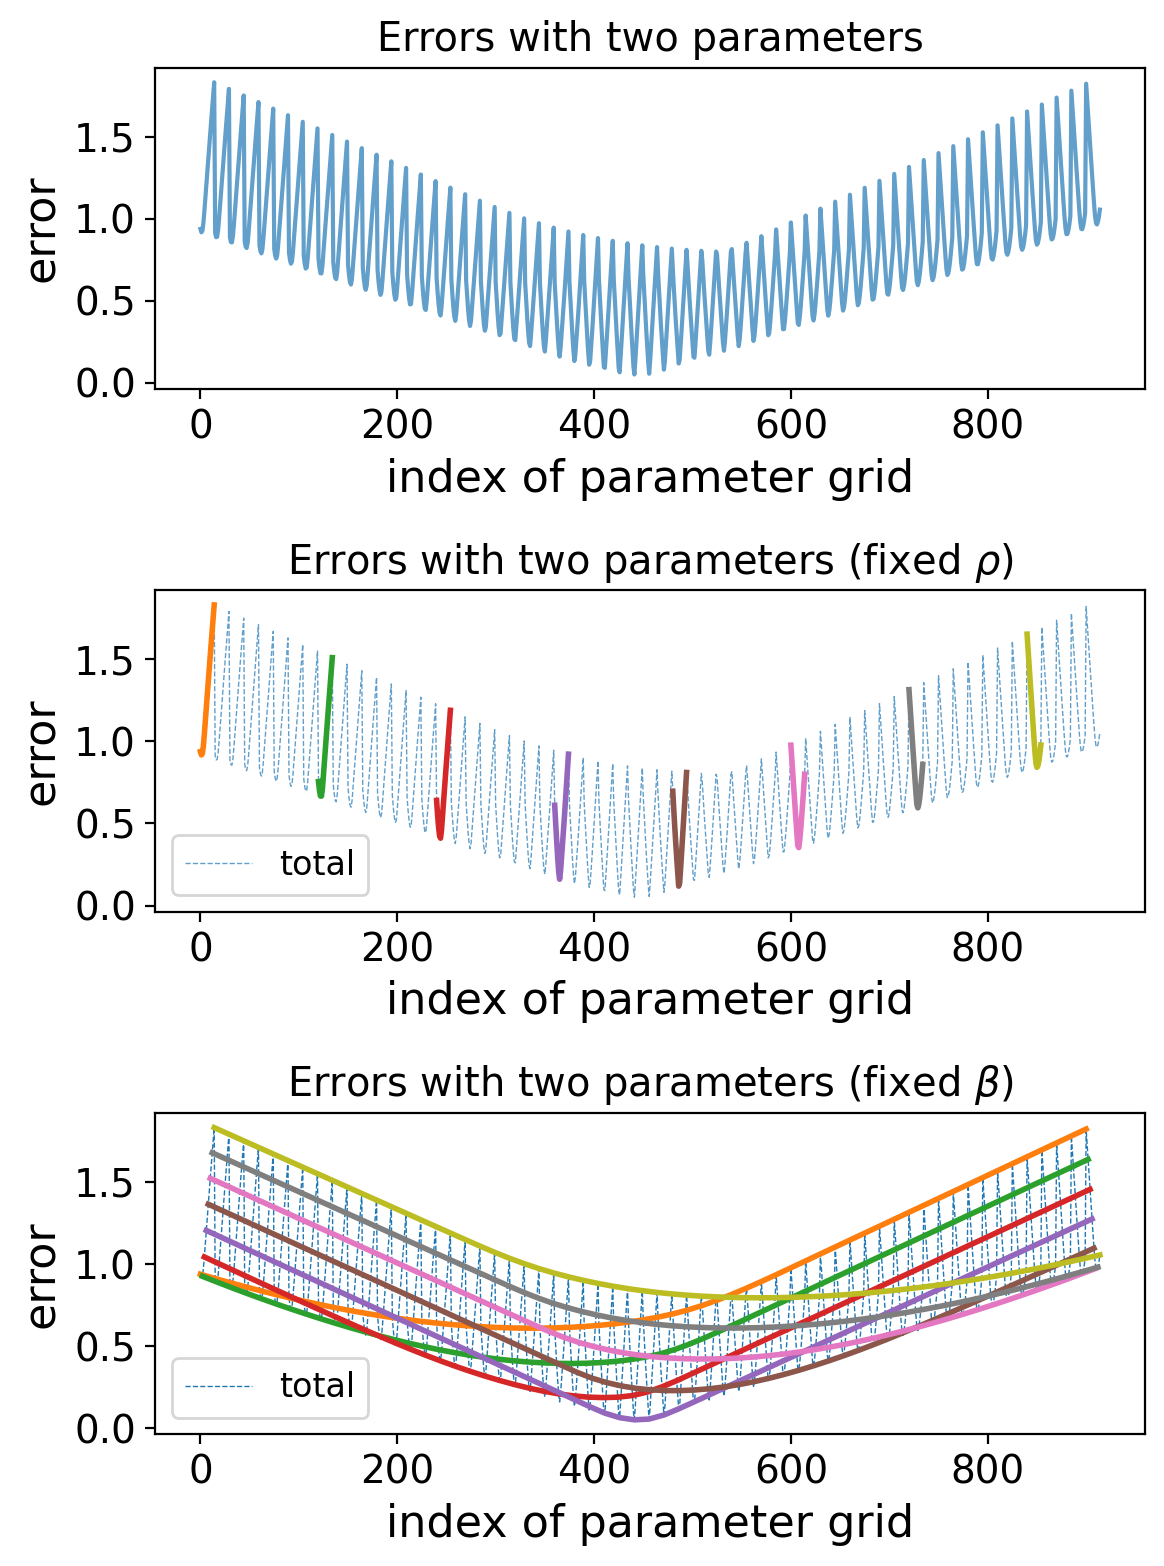

In [5]:
M=len(rho_value)
N=len(beta_value)

# plot errors
fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(3,1)  # GridSpec for custom layout

# --- Total plot ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.arange(M*N), sync_err_history, alpha=0.7)
ax1.set_xlabel("index of parameter grid")
ax1.set_ylabel("error")
ax1.set_title("Errors with two parameters")

# --- fixed rho ---
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(np.arange(M*N), sync_err_history, '--', alpha=0.7, label='total',linewidth=0.5)
for i in range(M):
    if i%8==0: # only plot some of them
        ax2.plot(np.arange(N*i,N*(i+1)), sync_err_history[N*i:N*(i+1)], linewidth=2)
ax2.set_xlabel("index of parameter grid")
ax2.set_ylabel("error")
ax2.set_title(r"Errors with two parameters (fixed $\rho$)")
ax2.legend()

# --- fixed beta ---
ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(np.arange(M*N), sync_err_history, '--', label='total',linewidth=0.5)
for i in range(N):
    if i%2==0: # only plot half of them
        ax3.plot(np.arange(M*N)[i::N], sync_err_history[i::N], linewidth=2)
ax3.set_xlabel("index of parameter grid")
ax3.set_ylabel("error")
ax3.set_title(r"Errors with two parameters (fixed $\beta$)")
ax3.legend()

plt.tight_layout()
plt.show()



For the last two plots, each color represents how error evolves with one parameter while the other one is fixed (only some of them). Both parameters will cause the decrease in errors in the beginning and increase later. The estimated parameters can be found by looking at the lowest errors in two plots on same color line and choose the smallest one among them.

To solve the driver-driven system, we use `scipy.interpolate.interp1d` to generate the value of x at any time as the driver. If our function $x(t)$ is underfitted or overfitted, this may contribute to an error in the estimate.

The grid search depends on the step of parameters. We choose 0.05 as a step here. A smaller step can give us a more accurate estimate but also takes more time and computational costs.